# 圧力仮定法による多層室換気計算のメインプログラム

## 疑問点  
- QOOは何を表す？

- NN=50
- NB=37  行列定義のための整数定数                

- G=9.80665：重力加速度
- KANWA=0.6：圧力偏差にかける緩和定数
- RAW=1.20156：20度における密度[kg/m^3]
- AI=0.7：A:初期条件決定のための流量係数
    
- D：開口状態
- ION：開口向き
    
- IC：インシデンス行列
- WS：何かわからないが０なので無視する。使っていない
- Q

- B：開口幅[mm]
- S：縦開口本数
- HU：開口上辺高さ[m]
- HD：開口下辺高さ[m]
- HS：床面差(開口を挟んだ室同士の床面の高さの差)[m]
- H：開口の高さ[m]

- QV：縦方向開口1Pa時[m^3/s]を長辺長さで割ったもの[m^2/s]
- QH：横方向開口の1Pa時[m^3/s]を長辺長さで割ったもの[m^2/s]
- SV：縦開口面積合計[m^2]
- SH：横開口面積[m^2]

- DRAW：密度差[kg/m^3]
- P：室圧力[Pa]
- DP：枝圧力[Pa]
- DDP：室圧力偏差[Pa]
- PS：起圧力[Pa]

- HN：中立軸高さ[m]
- HNU：上端から中立軸までの距離[m]
- HND：下端から中立軸までの距離[m]
- UC：下辺流量[kg/s]
- DUC：下辺[∂f/∂p]

- SS：縦開口流量
- SU：上辺流量
- DSS：縦開口[∂f/∂p]
- DSU：上辺[∂f/∂p]

- WU：開口正方向流量
- WD：開口負方向流量
- DWW：室正味流量
- DWU：開口正方向[∂f/∂p]
- DWD：開口負方向[∂f/∂p]
- W：開口の正味流量
- DW：開口[∂f/∂p]

- A：α流量係数[-]
- IDD：([I][∂f/∂p][I'])
- M：縦方向隙間特性値[-]
- MM：横方向隙間特性値[-]
- ERRLIM：誤差範囲
- DWWMAX：室の正味流量の最大値[]

- DDD,WTIME：使っていない、時間指定

- STEP：繰り返し変数（計算ステップ数）
- COUNT：誤差範囲拡大のための定数
- ERRLIMS：誤差範囲
- STLIM：誤差範囲拡大までのステップ数
- NON
- STEPC

- V_SM：同様枝数
- OPEN_DIR：開口方位
- DIR：風向きと開口の角度差[南０時計回り２２．５度でプラス１]
- WC：風圧係数[-]

計算条件

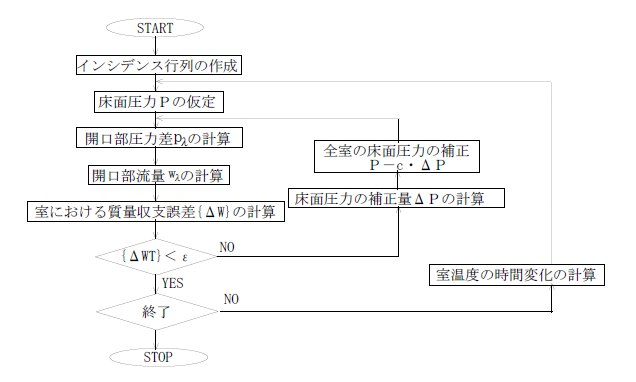

## 1. 計算モジュールのimport

In [1]:
include("module_calc_ventilation.jl")
include("multi_ventilation.jl")

cal_GAUSE (generic function with 1 method)

## 2. 空間の構成情報を定義

In [2]:
Network = Network_configuration_VENT()
Network.RM = 12
Network.BC = 38

38

## 3. 空間情報の定義と仮定床面圧力の設定  
空間の数はRM+1（外気）としておく。  
⇒　今後要修正？

In [33]:
Room = [ Room_condtion_VENT() for i = 1: Network.RM+1 ]
Room = cal_assum_floor_p( Network, Room );

# 温度・室体積の入力・密度の計算
for i = 1:length(Room)
    Room[i].TEM = 273.15 + 20.0 + 0.1 * i
    Room[i].VOL = 100.0
    Room[i].RAW = 353.25 / Room[i].TEM
end

### 3.A 外界気象条件の定義

In [34]:
Outdoor = Outdoor_condtion_VENT()

Outdoor_condtion_VENT(2.147298624e-315, 2.147480914e-315, 1.275372125e-315, 1.275372125e-315, 4.2e-322)

## 4. 開口条件の読み込み

In [35]:
Opening = cal_datin();

In [36]:
Network.BC = length(Opening)

7

### 4.A 風圧係数の読み込み

In [37]:
Opening = cal_WC( Opening );

### 4.B 枝の上下密度および密度差の計算

In [38]:
for i = 1 : Network.BC
    if Int(Opening[i].IP) ≠ 0
        Opening[i].RAW2_IP = 353.25 / Room[Int(Opening[i].IP)].TEM
    else
        Opening[i].RAW2_IP = 353.25 / Outdoor.TEM
    end
    
    if Int(Opening[i].IM) ≠ 0
        Opening[i].RAW2_IM = 353.25 / Room[Int(Opening[i].IM)].TEM
    else
        Opening[i].RAW2_IM = 353.25 / Outdoor.TEM
    end
    
    Opening[i].DRAW    = Opening[i].RAW2_IP - Opening[i].RAW2_IM
end

## 5. 既約インシデンス行列の作成

In [39]:
Network.IC = zeros( Int, Network.RM+1, Network.BC )
for i = 1 : Network.BC
    Network.IC[ Int(Opening[i].IP)+1, i ] = 1
    Network.IC[ Int(Opening[i].IM)+1, i ] =Int(-1)
end

## 6. 起圧力Psの計算

In [40]:
Opening = cal_PS( Network, Room, Outdoor, Opening );

In [46]:
[ Opening[i].PS for i =1:length(Opening) ]

7-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

# 繰り返し計算

In [41]:
# 圧力差の計算
for i = 1:Network.BC
    # 外気の有無で場合分けが必要
    if Int(Opening[i].IP) == 0
        Opening[i].DP =  Outdoor.P - Room[Int(Opening[i].IM)].P - Opening[i].PS
    elseif Int(Opening[i].IM) == 0
        Opening[i].DP =  Room[Int(Opening[i].IP)].P - Outdoor.P - Opening[i].PS            
    else
        Opening[i].DP =  Room[Int(Opening[i].IP)].P - Room[Int(Opening[i].IM)].P - Opening[i].PS
    end
end

## 7. 流量の計算

In [12]:
for i = 1:length(Opening)
    Opening[i].QV = cal_QV(Opening.AI, Opening.SV, Opening.RAW)
    Opening[i].QH = cal_QH(Opening.AI, Opening.SH, Opening.RAW)
end
Flux = cal_flux_ventilation_by_OC( Opening )
Room = cal_DWW( Network, Room, Flux )

LoadError: type Array has no field AI

### 7.1 流量誤差の計算

In [13]:
DWWMAX = 0.0
for i = 1 : Network.RM
    DWWMAX = max( DWWMAX, ABS(Flux[i].DWW) )
end

LoadError: UndefVarError: Flux not defined

In [14]:
    
# Qo計算 
# ⇒ 入力値としてQO（9.8Pa時の風量）を入れた際に1Pa時の値などに変換しなおす
#CALL QOCAL


In [15]:
function cal_main_ventilation() # 入力値を構造体化して引数とする
    # ~ moduleを用いた計算
    return # 構造体として出力
end

cal_main_ventilation (generic function with 1 method)

In [16]:
module Ventilation_Network_Model

const NN = 50
const NB = 60
const G  = 9.80665
const KANWA = 0.6

STEP   = 0.0
COUNT  = 0.0
ERRLIM = 1.0e-8
ERRLIMS= ERRLIM
STLIM  = 50.0


# 密度・起圧力計算
RAW2 = [ zone_Ps.cal_RAW2( temp2[i] ) for i = 1:RM+1 ]
DRAW = [ zone_Ps.cal_DRAW( RAW2[IP[i]], RAW2[ IM[i] ] ) for i = 1:BC ]
PS   = [ zone.Ps.cal_PS( BC, RM, IP[i], IM[i], HS[i], RAW2 ) for i = 1:BC ]

#end

LoadError: syntax: incomplete: "module" at In[16]:1 requires end

## 繰り返し計算

In [17]:
# 全体がループ

STEP = STEP + 1.0

# 圧力差の計算
for I = 1 : BC
    DP[i] = P[IP[I]] - P[IM[I]] - PS[I]
end
      
# 流量計算 
CALL FLCAL

#各室流量収支計算
# 枝の正味流量
    
#流量誤差の計算
    
if( DWWMAX * 3600.0 > ERRLIM );
    IDD = cal_IDD(RM)
      
    # 連立方程式計算
    DPP = cal_GAUSE( RM, DWW, IDD )
    
    # 修正圧力計算
    for II = 1 : RM
        P[II] = P[II] - KANWA * DDP[II]
    end

    if( STEP >= STLIM )
        COUNT = COUNT + 1.0
        ERRLIM= ERRLIMS * COUNT
    end
else
    break # 範囲外なら計算から抜け出す
end



LoadError: UndefVarError: STEP not defined

In [18]:
mutable struct Output_variables_VENT
    IP::Array{Int,1} # 枝の上流 0からBCまでの配列
    IM::Array{Int,1} # 枝の下流 0からBCまでの配列
    GGU::Array{Float64,1} # 上流から下流の流量[] 0からBCまでの配列
    GGD::Array{Float64,1} # 下流から上流の流量[] 0からBCまでの配列
    RAW1::Array{Float64,1} # 各室の空気密度[kg/m^3] 0からRMまでの配列
    GG::Array{Float64,1}   # 室に入る正味流量 0からRMまでの配列
    Output_variables_VENT() = new()
end

### 流量計算

In [19]:
for I = 1 : BC #要注意
    GGU[I] = WU[I]
    GGD[I] = WD[I]
    
    if IP[I] == RM+1; IP[I] = 0; end
    if IM[I] == RM+1; IM[I] = 0; end    
end

for II = 1, RM
    GG[II] = 0.0
    for I = 1, BC
        if IP[I] == II && WU(I) > 0;
            GG[II] = GG[II] + WU[I]
        elseif IM[I] == II && WD[I] > 0;
            GG[II] = GG[II] + WD[I]
        else
            GG[II] = GG[II]
        end
    end
end

LoadError: UndefVarError: BC not defined

### 出力（書出し）変数の定義  
室間の流量情報の出力  
※　使わない？

In [20]:
mutable struct Output_variables_VENT
    IP::Array{Int,1} # 枝の上流 0からBCまでの配列
    IM::Array{Int,1} # 枝の下流 0からBCまでの配列
    GGU::Array{Float64,1} # 上流から下流の流量[] 0からBCまでの配列
    GGD::Array{Float64,1} # 下流から上流の流量[] 0からBCまでの配列
    RAW1::Array{Float64,1} # 各室の空気密度[kg/m^3] 0からRMまでの配列
    GG::Array{Float64,1}   # 室に入る正味流量 0からRMまでの配列
    Output_variables_VENT() = new()
end